# Image Resconstrute

- Reference : 

1. https://arxiv.org/pdf/2111.12417v1.pdf
2. https://arxiv.org/pdf/2212.06714.pdf

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import visualkeras
import cv2
import os

In [2]:
CLASSES_NUM = 10

# Load Dataset

In [3]:
X_DATA_PATH = "./data/cropped/"
Y_DATA_PATH = "./data/resized/"

x_data_path_list = os.listdir(X_DATA_PATH)
y_data_path_list = os.listdir(Y_DATA_PATH)

X, y = list(), list()
for x_data_path in tqdm(x_data_path_list, desc=f'X data loading...'):   X.append(cv2.imread(X_DATA_PATH + x_data_path))
for y_data_path in tqdm(y_data_path_list, desc=f'Y data loading...'):   y.append(cv2.imread(Y_DATA_PATH + y_data_path))

Y data loading...: 100%|██████████| 5000/5000 [00:03<00:00, 1662.68it/s]


In [4]:
X = np.array(X)[:,:,:,0]
y = np.array(y)[:,:,:,0]

scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y = scaler.fit_transform(y.reshape(-1, 1)).reshape(y.shape)

print(f"""X shape: {X.shape}
y shape: {y.shape}""")

X shape: (5000, 256, 256)
y shape: (5000, 256, 256)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"""X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
X_test shape: {X_test.shape}
y_test shape: {y_test.shape}""")

X_train shape: (4000, 256, 256)
y_train shape: (4000, 256, 256)
X_test shape: (1000, 256, 256)
y_test shape: (1000, 256, 256)


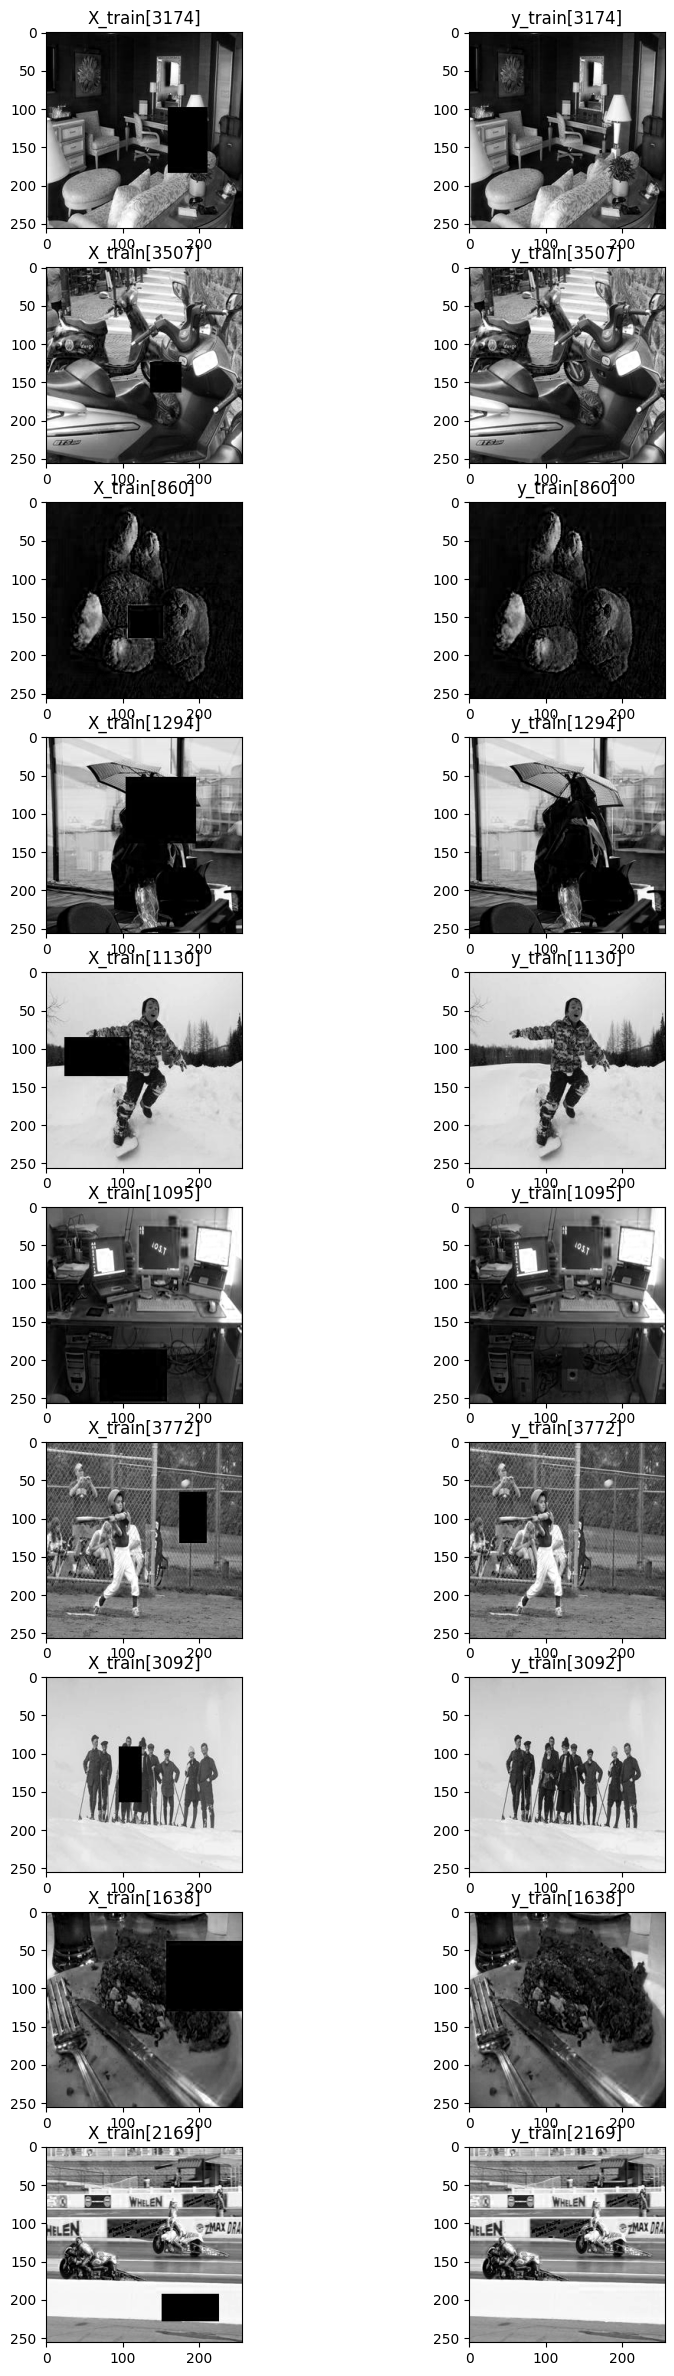

In [6]:
np.random.seed(42)

randlist = np.random.randint(0, X_train.shape[0], 10)

ax, fig = plt.subplots(10, 2, figsize=(10, 30))
for i, j in zip(range(10), randlist):
    fig[i][0].title.set_text(f"X_train[{j}]")
    fig[i][1].title.set_text(f"y_train[{j}]")
    fig[i][0].imshow(X_train[j], cmap='gray')
    fig[i][1].imshow(y_train[j], cmap='gray')
plt.show()

# Modeling

In [63]:
# Convolution Encoder Decoder
input_layer = layers.Input(shape=(X_train.shape[1], X_train.shape[2], 1))

# Encoder
x1 = layers.Conv2D(16, (3, 3), strides=2, padding='same')(input_layer)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('relu')(x1)
x1_16channel = x1

x1 = layers.Conv2D(32, (3, 3), strides=2, padding='same')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('relu')(x1)
x1_32channel = x1

x1 = layers.Conv2D(64, (3, 3), strides=2, padding='same')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('relu')(x1)
x1 = layers.MaxPooling2D((2, 2))(x1)
x1_64channel = x1

x1 = layers.Conv2D(128, (3, 3), strides=2, padding='same')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('relu')(x1)
x1 = layers.MaxPooling2D((2, 2))(x1)
x1_128channel = x1

# Latent Space
x1 = layers.Conv2D(256, (3, 3), padding='same')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('relu')(x1)

# Decoder
x1 = layers.Conv2DTranspose(128, (3, 3), padding='same')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('relu')(x1)
x1 = layers.Concatenate()([x1, x1_128channel])

x1 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('relu')(x1)
x1 = layers.UpSampling2D((2, 2))(x1)
x1 = layers.Concatenate()([x1, x1_64channel])

x1 = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('relu')(x1)
x1 = layers.UpSampling2D((2, 2))(x1)
x1 = layers.Concatenate()([x1, x1_32channel])

x1 = layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('relu')(x1)

x1 = layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation('sigmoid')(x1)

x1 = layers.Conv2D(1, (1, 1), strides=1, padding='same')(x1)

y1 = x1

model = keras.Model(input_layer, y1)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_98 (Conv2D)          (None, 127, 127, 16)         160       ['input_19[0][0]']            
                                                                                                  
 conv2d_99 (Conv2D)          (None, 125, 125, 16)         2320      ['conv2d_98[0][0]']           
                                                                                                  
 batch_normalization_170 (B  (None, 125, 125, 16)         64        ['conv2d_99[0][0]']           
 atchNormalization)                                                                        

In [64]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_98 (Conv2D)          (None, 127, 127, 16)         160       ['input_19[0][0]']            
                                                                                                  
 conv2d_99 (Conv2D)          (None, 125, 125, 16)         2320      ['conv2d_98[0][0]']           
                                                                                                  
 batch_normalization_170 (B  (None, 125, 125, 16)         64        ['conv2d_99[0][0]']           
 atchNormalization)                                                                        

In [65]:
optimzier = tf.keras.optimizers.Adam(learning_rate=0.03)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimzier, loss=[loss, loss], metrics=['accuracy'])

# Model Training

In [66]:
outDir = './checkpoint_concated/' # 이 경로에 best 모델이 저장된다.
model_names = outDir + 'weights-{epoch}-{val_loss:.4f}.h5'
def get_callbacks(patience = 50):
    model_checkpoint = ModelCheckpoint(model_names, monitor='val_loss', verbose=1, save_best_only=True, period = 1)
    callbacks = [model_checkpoint]
    return callbacks

callback = get_callbacks()

In [67]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[callback]
)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 608.2366 - accuracy: 0.0209
Epoch 1: val_loss improved from inf to 572.80798, saving model to ./checkpoint_concated/weights-1-572.8080.h5
125/125 [==============================] - 63s 473ms/step - loss: 608.2366 - accuracy: 0.0209 - val_loss: 572.8080 - val_accuracy: 0.0180
Epoch 2/100


/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - ETA: 0s - loss: 576.0337 - accuracy: 0.0239
Epoch 2: val_loss improved from 572.80798 to 572.58282, saving model to ./checkpoint_concated/weights-2-572.5828.h5
125/125 [==============================] - 54s 433ms/step - loss: 576.0337 - accuracy: 0.0239 - val_loss: 572.5828 - val_accuracy: 0.0280
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 575.2279 - accuracy: 0.0251
Epoch 3: val_loss did not improve from 572.58282
125/125 [==============================] - 53s 427ms/step - loss: 575.2279 - accuracy: 0.0251 - val_loss: 589.3150 - val_accuracy: 0.0288
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 574.7833 - accuracy: 0.0258
Epoch 4: val_loss did not improve from 572.58282
125/125 [==============================] - 53s 427ms/step - loss: 574.7833 - accuracy: 0.0258 - val_loss: 598.8972 - val_accuracy: 0.0288
Epoch 5/100
125/125 [==============================] - ETA: 0s - loss: 574.4645 - accur

# Result

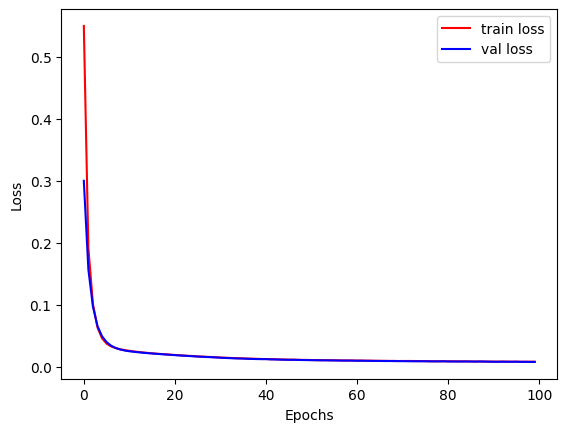

In [38]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, 'r', label='train loss')
plt.plot(val_loss, 'b', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Evaluation

In [39]:
trained_model_path = sorted(os.listdir(outDir))
pretrained_model_file = outDir + trained_model_path[-1]
print(f"pretrained_model_file: {pretrained_model_file}")

pretrained_model = keras.models.load_model(pretrained_model_file)

pretrained_model_file: ./checkpoint/weights-99-0.0077.h5


In [40]:
y_pred = pretrained_model.predict(X_test)

32/32 [==============================] - 2s 52ms/step


In [41]:
print(f"""y_pred shape: {y_pred.shape}
y_test shape: {y_test.shape}""")

y_pred shape: (1000, 256, 256, 1)
y_test shape: (1000, 256, 256)


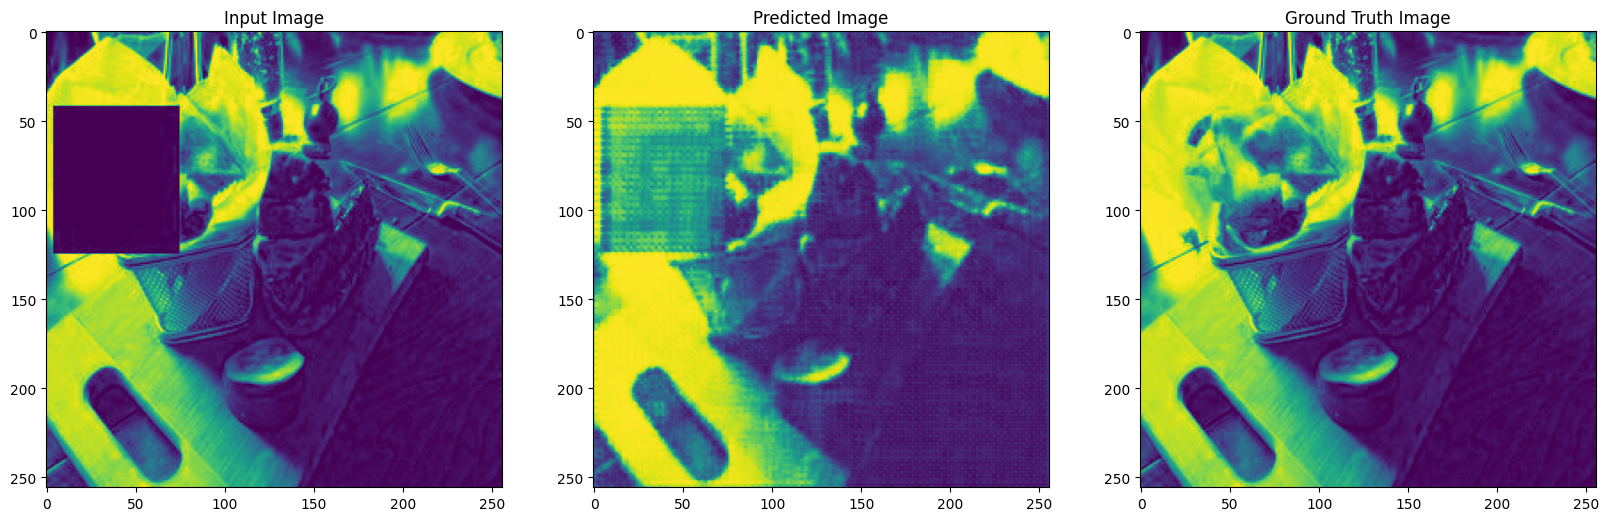

In [51]:
IMAGE_SELECT = 23

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(X_test[IMAGE_SELECT])
ax[0].set_title('Input Image')
ax[1].imshow(y_pred[IMAGE_SELECT])
ax[1].set_title('Predicted Image')
ax[2].imshow(y_test[IMAGE_SELECT])
ax[2].set_title('Ground Truth Image')
plt.show()